### **Importación de los datos del precio nacional del cacao**

In [28]:
import pandas as pd

# Cargar el archivo Excel
df_precio_nacional = pd.read_excel("DatosAgroNet_limpio.xlsx")

# Mostrar las primeras filas
print(df_precio_nacional.head())

       Fecha   COP/kg
0 2023-01-02  10095.0
1 2023-01-09  10462.2
2 2023-01-16  10530.8
3 2023-01-23  10580.0
4 2023-01-30  10820.0


### **Importación de los datos del precio internacional del cacao**

In [29]:
# Cargar el archivo
df_precio_int = pd.read_excel("DatosICCO_limpio.xlsx")

df_precio_int.rename(columns={'COP/kg': 'COP/kg (internacional)'}, inplace=True)

# Mostrar las primeras filas
print(df_precio_int.head())

       Fecha  USD/tonelada      TRM  COP/kg (internacional)
0 2025-08-15       7831.32  4048.74                31706.98
1 2025-08-14       7848.47  4020.64                31555.87
2 2025-08-13       8129.07  4017.12                32655.45
3 2025-08-12       8163.01  4045.87                33026.48
4 2025-08-11       8013.19  4034.74                32331.14


### **Importación de los datos de inflación nacional**

In [30]:
# Cargar el archivo
df_inflacion = pd.read_excel("Inflacion_mensual.xlsx")

# Limpiar y preparar los datos
df_inflacion = df_inflacion.drop(df_inflacion.index[0])
df_inflacion = df_inflacion.drop(df_inflacion.index[-1])
df_inflacion["Fecha"] = pd.to_datetime(df_inflacion["Fecha"], format="%d/%m/%Y")

df_inflacion.rename(columns={'Inflación total(Dato fin de mes)': 'Inflacion'}, inplace=True)
df_inflacion["Inflacion"] = df_inflacion["Inflacion"].str.replace(",", ".").astype(float)

# Mostrar las primeras filas
print(df_inflacion.head())
print(df_inflacion.shape)

       Fecha  Inflacion
1 1955-07-31      -0.87
2 1955-08-31      -0.01
3 1955-09-30       0.84
4 1955-10-31       0.77
5 1955-11-30       1.44
(844, 2)


In [31]:
# Rango semanal desde la primera hasta la última fecha del df
fechas_semanales = pd.date_range(
    start=df_inflacion["Fecha"].min(),
    end=df_inflacion["Fecha"].max(),
    freq="D"   # frecuencia diaria
)

df_inflacion_adj = pd.DataFrame({"Fecha": fechas_semanales})

# Agregar columnas auxiliares de año y mes
df_inflacion["Año"] = df_inflacion["Fecha"].dt.year
df_inflacion["Mes"] = df_inflacion["Fecha"].dt.month

df_inflacion_adj["Año"] = df_inflacion_adj["Fecha"].dt.year
df_inflacion_adj["Mes"] = df_inflacion_adj["Fecha"].dt.month

# Merge para traer la inflación mensual a cada dia
df_inflacion_adj = df_inflacion_adj.merge(
    df_inflacion[["Año", "Mes", "Inflacion"]],
    on=["Año", "Mes"],
    how="left"
)

df_inflacion_adj = df_inflacion_adj.drop(columns=["Año", "Mes"])

print(df_inflacion_adj.head())

       Fecha  Inflacion
0 1955-07-31      -0.87
1 1955-08-01      -0.01
2 1955-08-02      -0.01
3 1955-08-03      -0.01
4 1955-08-04      -0.01


### **Importación de los datos del precio de contratos futuros de cacao**

In [32]:
# Cargar el archivo
df_futuros = pd.read_csv("Precio_futuros.csv")

# Limpiar y preparar los datos
df_futuros = df_futuros.drop(columns=["London futures (£ sterling/tonne)","ICCO daily price (US$/tonne)","ICCO daily price (Euro/tonne)"])
df_futuros["Date"] = pd.to_datetime(df_futuros["Date"], format="%d/%m/%Y")
df_futuros.rename(columns={'Date': 'Fecha'}, inplace=True)

df_futuros.rename(columns={"New York futures (US$/tonne)": 'Futuros (USD/tonelada)'}, inplace=True)
df_futuros["Futuros (USD/tonelada)"] = df_futuros["Futuros (USD/tonelada)"].str.replace(",", "").astype(float)

# Mostrar las primeras filas
print(df_futuros.head())
print(df_futuros.shape)

       Fecha  Futuros (USD/tonelada)
0 2025-09-01                 7496.00
1 2025-08-29                 7580.00
2 2025-08-28                 7611.67
3 2025-08-27                 7653.00
4 2025-08-26                 7490.00
(6595, 2)


### **Merge de las bases de datos en una sola unificada**

In [33]:
# Crear un rango de fechas completo basado en el nacional
fechas_completas = pd.DataFrame({'Fecha': pd.date_range(
    start=df_precio_nacional['Fecha'].min(),
    end=df_precio_nacional['Fecha'].max()
)})

# Forward fill para los dataframe con fechas sin datos
df_precio_int_ffill = fechas_completas.merge(df_precio_int[['Fecha', 'TRM', 'COP/kg (internacional)']], on='Fecha', how='left')
df_precio_int_ffill[['TRM', 'COP/kg (internacional)']] = df_precio_int_ffill[['TRM', 'COP/kg (internacional)']].ffill()

df_futuros_ffill = fechas_completas.merge(df_futuros[['Fecha', 'Futuros (USD/tonelada)']], on='Fecha', how='left')
df_futuros_ffill['Futuros (USD/tonelada)'] = df_futuros_ffill['Futuros (USD/tonelada)'].ffill()


In [34]:
df_unificado = df_precio_nacional.copy()

df_unificado = df_unificado.merge(df_precio_int_ffill, on='Fecha', how='left')
df_unificado = df_unificado.merge(df_inflacion_adj[['Fecha', 'Inflacion']], on='Fecha', how='left')
df_unificado = df_unificado.merge(df_futuros_ffill, on='Fecha', how='left')

df_unificado["COP/kg (futuro)"] = ((df_unificado["Futuros (USD/tonelada)"] * df_unificado["TRM"]) / 1000).round(2)
df_unificado = df_unificado.drop(columns=["Futuros (USD/tonelada)"])

print(df_unificado.head())

# Guardar el DataFrame unificado en un nuevo archivo Excel
df_unificado.to_excel("DatosCacao_multivariado.xlsx", index=False)

       Fecha   COP/kg      TRM  COP/kg (internacional)  Inflacion  \
0 2023-01-02  10095.0      NaN                     NaN      13.25   
1 2023-01-09  10462.2  4885.66                12625.18      13.25   
2 2023-01-16  10530.8  4693.99                12011.69      13.25   
3 2023-01-23  10580.0  4631.64                11760.57      13.25   
4 2023-01-30  10820.0  4548.50                11704.38      13.25   

   COP/kg (futuro)  
0              NaN  
1         13160.36  
2         12465.69  
3         12141.06  
4         12035.33  


In [35]:
# Ver si hay duplicados
print("¿Hay duplicados?:", df_unificado.duplicated().any())  # True si existe al menos un duplicado
print("Número de filas duplicadas:", df_unificado.duplicated().sum())

# Ver si hay nulos
print("\nCantidad de nulos por columna:")
print(df_unificado.isnull().sum())

df_unificado.fillna(method='bfill', inplace=True)

¿Hay duplicados?: False
Número de filas duplicadas: 0

Cantidad de nulos por columna:
Fecha                     0
COP/kg                    0
TRM                       1
COP/kg (internacional)    1
Inflacion                 0
COP/kg (futuro)           1
dtype: int64


C:\Users\peter\AppData\Local\Temp\ipykernel_9648\2684744992.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_unificado.fillna(method='bfill', inplace=True)


### **Gráficos de los datos finales**

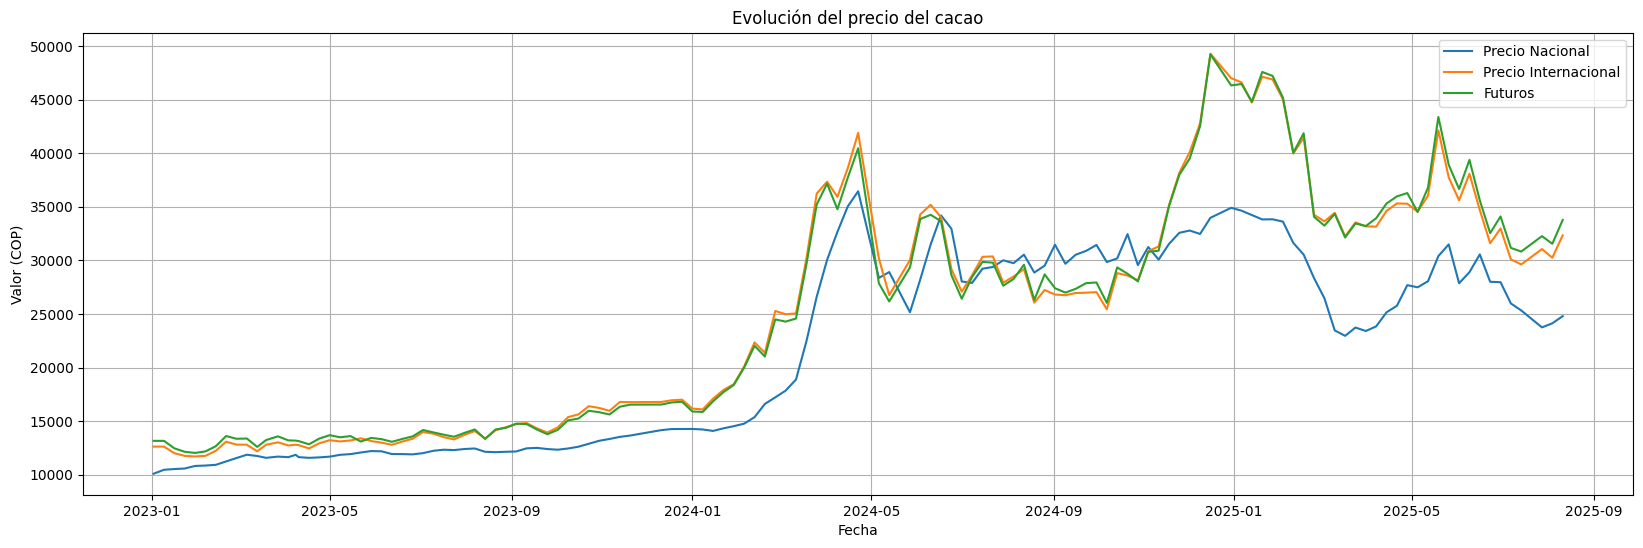

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,6))

plt.plot(df_unificado["Fecha"], df_unificado["COP/kg"], label="Precio Nacional")
plt.plot(df_unificado["Fecha"], df_unificado["COP/kg (internacional)"], label="Precio Internacional")
plt.plot(df_unificado["Fecha"], df_unificado["COP/kg (futuro)"], label="Futuros")

plt.title("Evolución del precio del cacao")
plt.xlabel("Fecha")
plt.ylabel("Valor (COP)")
plt.legend()
plt.grid(True)
plt.show()


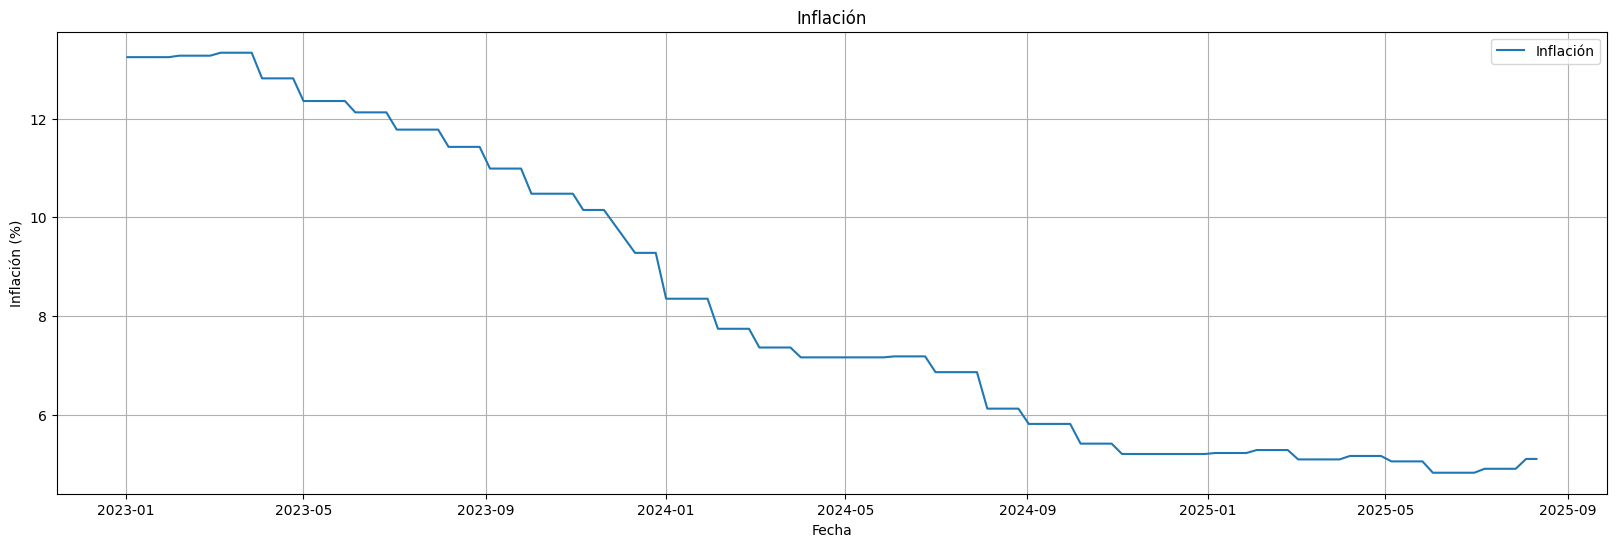

In [37]:
plt.figure(figsize=(20,6))
plt.plot(df_unificado["Fecha"], df_unificado["Inflacion"], label="Inflación")
plt.title("Inflación")
plt.xlabel("Fecha")
plt.ylabel("Inflación (%)")
plt.legend()
plt.grid(True)
plt.show()

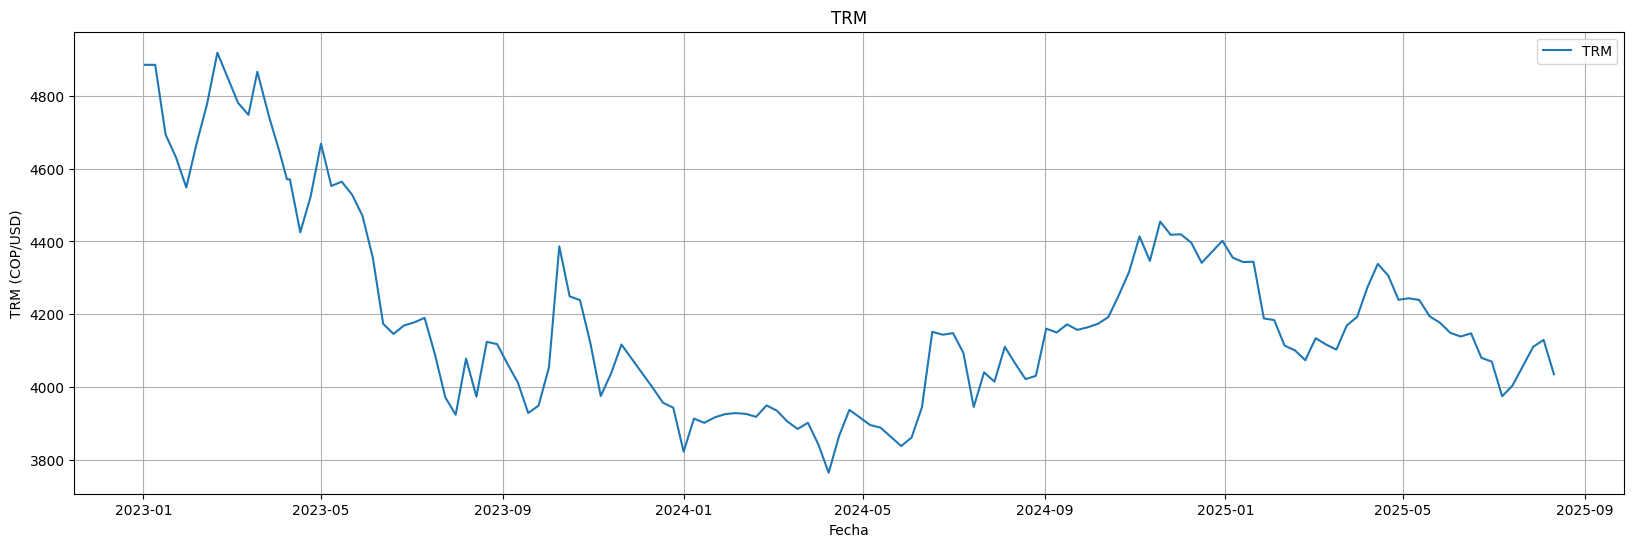

In [38]:
plt.figure(figsize=(20,6))
plt.plot(df_unificado["Fecha"], df_unificado["TRM"], label="TRM")
plt.title("TRM")
plt.xlabel("Fecha")
plt.ylabel("TRM (COP/USD)")
plt.legend()
plt.grid(True)
plt.show()

### **Pruebas de estacionaridad y cointegración para las variables a usar**

In [39]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    return result[1]  # p-value

def kpss_test(series):
    result = kpss(series.dropna(), regression='c', nlags="auto")
    return result[1]  # p-value

def estacionaridad_tests(df):
    resultados = []
    for col in df.columns:
        try:
            adf_p = adf_test(df[col])
            kpss_p = kpss_test(df[col])
            
            if adf_p < 0.05 and kpss_p > 0.05:
                conclusion = "Estacionaria"
            elif adf_p > 0.05 and kpss_p < 0.05:
                conclusion = "No estacionaria"
            else:
                conclusion = "Inconcluso / revisar"
            
            resultados.append({
                "Variable": col,
                "ADF p-value": round(adf_p, 4),
                "KPSS p-value": round(kpss_p, 4),
                "Conclusión": conclusion
            })
        except Exception as e:
            resultados.append({
                "Variable": col,
                "ADF p-value": None,
                "KPSS p-value": None,
                "Conclusión": f"Error: {e}"
            })
    
    return pd.DataFrame(resultados)


resultados_est = estacionaridad_tests(df_unificado.drop(columns=["Fecha"]))
print(resultados_est)


                 Variable  ADF p-value  KPSS p-value       Conclusión
0                  COP/kg       0.5531        0.0100  No estacionaria
1                     TRM       0.0778        0.0255  No estacionaria
2  COP/kg (internacional)       0.5875        0.0100  No estacionaria
3               Inflacion       0.3457        0.0100  No estacionaria
4         COP/kg (futuro)       0.5910        0.0100  No estacionaria


C:\Users\peter\AppData\Local\Temp\ipykernel_9648\439823062.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")
C:\Users\peter\AppData\Local\Temp\ipykernel_9648\439823062.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")
C:\Users\peter\AppData\Local\Temp\ipykernel_9648\439823062.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")
C:\Users\peter\AppData\Local\Temp\ipykernel_9648\439823062.py:8: InterpolationWarning: The test statistic is outsid

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Prueba de cointegración de Johansen
johansen_test = coint_johansen(df_unificado.drop(columns=["Fecha"]), det_order=1, k_ar_diff=1)

# Resultados explicitos
print("Estadísticos de traza:", johansen_test.lr1)
print("Valores críticos (90%,95%,99%):", johansen_test.cvt)


Estadísticos de traza: [70.40768078 40.20600695 21.6126213   7.5331385   0.73469127]
Valores críticos (90%,95%,99%): [[75.1027 79.3422 87.7748]
 [51.6492 55.2459 62.5202]
 [32.0645 35.0116 41.0815]
 [16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]


In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def johansen_test_summary(df, det_order=1, k_ar_diff=2, alpha=0.05):

    test = coint_johansen(df, det_order=det_order, k_ar_diff=k_ar_diff)
    
    # 0=90%, 1=95%, 2=99%
    crit_index = {0.10: 0, 0.05: 1, 0.01: 2}[alpha]
    
    # Determinar rango de cointegración
    r = 0
    for i in range(len(test.lr1)):
        if test.lr1[i] > test.cvt[i, crit_index]:
            r += 1
        else:
            break
    
    # Imprimir resultado
    if r == 0:
        print(f"No se encontró cointegración al {int((1-alpha)*100)}% de confianza.")
    elif r == 1:
        print("Se encontró 1 relación de cointegración → puedes usar VECM.")
    else:
        print(f"Se encontraron {r} relaciones de cointegración → aplica VECM.")
    
    return r

df_sin_fecha = df_unificado.drop(columns=['Fecha'])
johansen_test_summary(df_sin_fecha)


No se encontró cointegración al 95% de confianza.


0